# **Imports**

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import  DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

# **Load Dataset**

## Train

In [2]:
df_train = pd.read_csv('./data/train.csv')
x_train = df_train.drop('MedHouseVal', axis=1)
y_train = df_train['MedHouseVal']

In [3]:
x_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.4817,6,4.443645,1.134293,1397,3.350120,36.77,-119.84
1,6.9133,8,5.976471,1.026471,862,2.535294,33.68,-117.80
2,1.5536,25,4.088785,1.000000,931,4.350467,36.60,-120.19
3,1.5284,31,2.740088,1.008811,597,2.629956,34.10,-118.32
4,4.0815,21,5.166667,1.002688,1130,3.037634,37.79,-121.23
...,...,...,...,...,...,...,...,...
16507,3.0625,20,5.860000,1.112000,745,2.980000,39.59,-121.90
16508,2.6133,49,5.163755,1.100437,1131,2.469432,38.11,-122.25
16509,4.4958,19,5.899767,1.074592,1206,2.811189,38.92,-121.22
16510,2.5750,39,3.591203,1.086675,2546,3.293661,34.16,-118.14


In [4]:
y_train

0        0.720
1        2.741
2        0.583
3        2.000
4        1.179
         ...  
16507    0.938
16508    1.031
16509    1.926
16510    1.535
16511    0.811
Name: MedHouseVal, Length: 16512, dtype: float64

## Test

In [5]:
df_test = pd.read_csv('./data/test.csv')
x_test = df_test.drop('MedHouseVal', axis=1)
y_test = df_test['MedHouseVal']

# **Preprocessing**

## Convert to tensor

### Train

In [6]:
x_train.values.shape

(16512, 8)

In [7]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_train

tensor([[   1.4817,    6.0000,    4.4436,  ...,    3.3501,   36.7700,
         -119.8400],
        [   6.9133,    8.0000,    5.9765,  ...,    2.5353,   33.6800,
         -117.8000],
        [   1.5536,   25.0000,    4.0888,  ...,    4.3505,   36.6000,
         -120.1900],
        ...,
        [   4.4958,   19.0000,    5.8998,  ...,    2.8112,   38.9200,
         -121.2200],
        [   2.5750,   39.0000,    3.5912,  ...,    3.2937,   34.1600,
         -118.1400],
        [   2.2478,   31.0000,    5.1238,  ...,    2.9976,   40.8000,
         -124.1300]])

In [8]:
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_train

tensor([0.7200, 2.7410, 0.5830,  ..., 1.9260, 1.5350, 0.8110])

### Test

In [9]:
x_test = torch.FloatTensor(x_test.values)
y_test = torch.FloatTensor(y_test.values)

## Normalize

In [10]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

In [11]:
x_train = (x_train - mu) / std

In [12]:
x_train.mean(dim=0), x_train.std(dim=0)

(tensor([ 1.6383e-07, -1.3862e-09, -5.4984e-08,  8.3169e-08, -1.7188e-07,
          1.4555e-08, -1.5668e-06,  1.3101e-06]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

In [13]:
x_test = (x_test - mu) / std

In [14]:
x_test.mean(dim=0)

tensor([ 0.0174,  0.0059,  0.0357,  0.0232, -0.0412, -0.0045,  0.0125, -0.0141])

In [15]:
x_test.std(dim=0)

tensor([1.0173, 0.9952, 1.3752, 1.2463, 0.8829, 0.7154, 0.9926, 0.9963])

# **Dataloader**

In [16]:
train_dataset = TensorDataset(x_train, y_train)
train_dataset

In [17]:
train_dataset.tensors

(tensor([[-1.2584, -1.7959, -0.4252,  ...,  0.0247,  0.5345, -0.1376],
         [ 1.6106, -1.6371,  0.2473,  ..., -0.0499, -0.9100,  0.8798],
         [-1.2204, -0.2877, -0.5809,  ...,  0.1162,  0.4551, -0.3122],
         ...,
         [ 0.3337, -0.7640,  0.2137,  ..., -0.0246,  1.5396, -0.8259],
         [-0.6809,  0.8236, -0.7992,  ...,  0.0195, -0.6856,  0.7102],
         [-0.8537,  0.1886, -0.1268,  ..., -0.0076,  2.4185, -2.2772]]),
 tensor([0.7200, 2.7410, 0.5830,  ..., 1.9260, 1.5350, 0.8110]))

In [18]:
train_dataset.tensors[0]

tensor([[-1.2584, -1.7959, -0.4252,  ...,  0.0247,  0.5345, -0.1376],
        [ 1.6106, -1.6371,  0.2473,  ..., -0.0499, -0.9100,  0.8798],
        [-1.2204, -0.2877, -0.5809,  ...,  0.1162,  0.4551, -0.3122],
        ...,
        [ 0.3337, -0.7640,  0.2137,  ..., -0.0246,  1.5396, -0.8259],
        [-0.6809,  0.8236, -0.7992,  ...,  0.0195, -0.6856,  0.7102],
        [-0.8537,  0.1886, -0.1268,  ..., -0.0076,  2.4185, -2.2772]])

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
train_loader

In [20]:
train_loader.batch_size

128

In [21]:
train_loader.dataset.tensors

(tensor([[-1.2584, -1.7959, -0.4252,  ...,  0.0247,  0.5345, -0.1376],
         [ 1.6106, -1.6371,  0.2473,  ..., -0.0499, -0.9100,  0.8798],
         [-1.2204, -0.2877, -0.5809,  ...,  0.1162,  0.4551, -0.3122],
         ...,
         [ 0.3337, -0.7640,  0.2137,  ..., -0.0246,  1.5396, -0.8259],
         [-0.6809,  0.8236, -0.7992,  ...,  0.0195, -0.6856,  0.7102],
         [-0.8537,  0.1886, -0.1268,  ..., -0.0076,  2.4185, -2.2772]]),
 tensor([0.7200, 2.7410, 0.5830,  ..., 1.9260, 1.5350, 0.8110]))

In [22]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 8]) torch.Size([128])


In [23]:
for i, (x_batch, y_batch) in enumerate(train_loader):
    print(i, x_batch.shape, y_batch.shape)

0 torch.Size([128, 8]) torch.Size([128])
1 torch.Size([128, 8]) torch.Size([128])
2 torch.Size([128, 8]) torch.Size([128])
3 torch.Size([128, 8]) torch.Size([128])
4 torch.Size([128, 8]) torch.Size([128])
5 torch.Size([128, 8]) torch.Size([128])
6 torch.Size([128, 8]) torch.Size([128])
7 torch.Size([128, 8]) torch.Size([128])
8 torch.Size([128, 8]) torch.Size([128])
9 torch.Size([128, 8]) torch.Size([128])
10 torch.Size([128, 8]) torch.Size([128])
11 torch.Size([128, 8]) torch.Size([128])
12 torch.Size([128, 8]) torch.Size([128])
13 torch.Size([128, 8]) torch.Size([128])
14 torch.Size([128, 8]) torch.Size([128])
15 torch.Size([128, 8]) torch.Size([128])
16 torch.Size([128, 8]) torch.Size([128])
17 torch.Size([128, 8]) torch.Size([128])
18 torch.Size([128, 8]) torch.Size([128])
19 torch.Size([128, 8]) torch.Size([128])
20 torch.Size([128, 8]) torch.Size([128])
21 torch.Size([128, 8]) torch.Size([128])
22 torch.Size([128, 8]) torch.Size([128])
23 torch.Size([128, 8]) torch.Size([128])
24

In [24]:
len(train_loader)

129

In [25]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, x_batch.shape

(torch.Size([128, 8]), torch.Size([128, 8]))

In [26]:
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)

# **Define Model**

In [35]:
num_feats = 8
out_feats = 1

h1 = 64
h2 = 32

model = nn.Sequential(
    nn.Linear(in_features=num_feats, out_features=h1),
    nn.ReLU(),
    nn.Linear(in_features=h1, out_features=h2),
    nn.ReLU(),
    nn.Linear(in_features=h2, out_features=out_feats)
)

In [36]:
model

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

# **Loss & Optimizer**

In [37]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# **Train Loooooop!**

In [38]:
num_epochs = 400

loss_train_hist = []
loss_test_hist = []

for epoch in range(num_epochs):
    loss_train = 0
    for x_batch, y_batch in train_loader:
        y_p = model(x_batch)
        loss = loss_fn(y_p.squeeze(), y_batch)
        loss_train += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_test = 0
    for x_batch, y_batch in test_loader:
        y_p = model(x_batch)
        loss_test += loss_fn(y_p.squeeze(), y_batch)

    loss_total_train = loss_train / len(train_loader)
    loss_total_test = loss_test / len(test_loader)

    loss_train_hist.append(loss_total_train.detach())
    loss_test_hist.append(loss_total_test.detach())

    if epoch % 50 == 0:
        print(f'Epoch = {epoch}, Loss Train = {loss_total_train:.4}')
        print(f'Epoch = {epoch}, Loss Test = {loss_total_test:.4}')
        print()

Epoch = 0, Loss Train = 3.805
Epoch = 0, Loss Test = 2.254

Epoch = 50, Loss Train = 0.4675
Epoch = 50, Loss Test = 0.4664

Epoch = 100, Loss Train = 0.4178
Epoch = 100, Loss Test = 0.4171

Epoch = 150, Loss Train = 0.3889
Epoch = 150, Loss Test = 0.3883

Epoch = 200, Loss Train = 0.3683
Epoch = 200, Loss Test = 0.3679

Epoch = 250, Loss Train = 0.3531
Epoch = 250, Loss Test = 0.3526

Epoch = 300, Loss Train = 0.3408
Epoch = 300, Loss Test = 0.3404

Epoch = 350, Loss Train = 0.3308
Epoch = 350, Loss Test = 0.3307



# **Learning Curve**

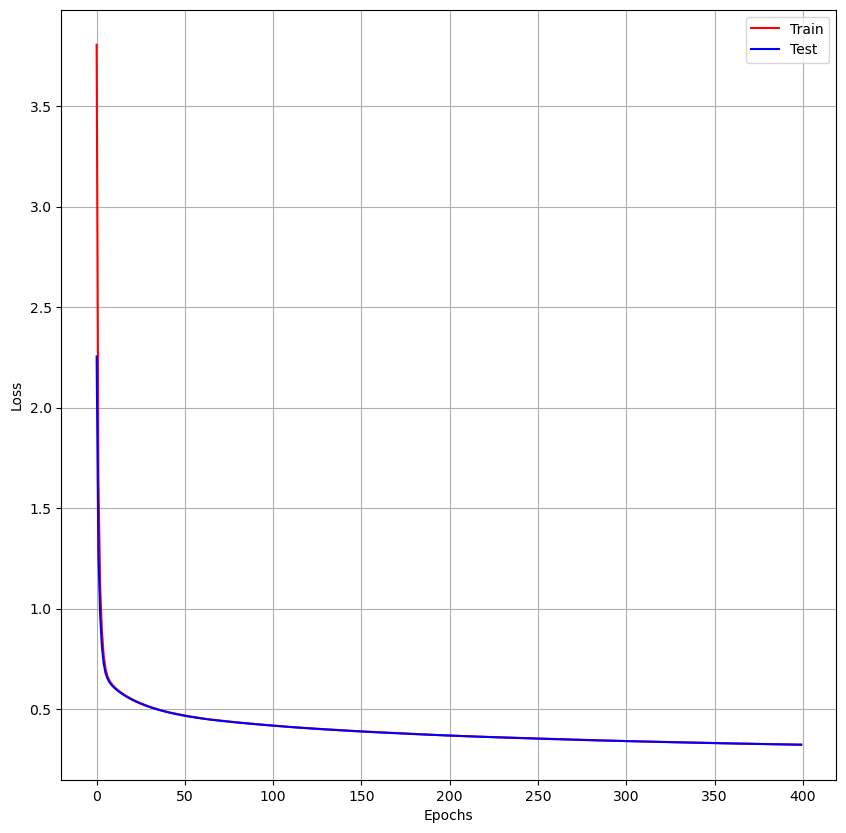

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
ax.plot(range(num_epochs), loss_test_hist, 'b-', label='Test')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend()

# **Prediction**

In [40]:
yp_total = []
yt_total = []

with torch.no_grad():
    for x, y in test_loader:
        yp = model(x)
        yp_total.append(yp.squeeze())
        yt_total.append(y)

In [44]:
yp_total = torch.cat(yp_total)
yt_total = torch.cat(yt_total)

In [45]:
r2_score(yp_total, yt_total)

0.6716058642954605